In [71]:
import spacy
import pandas as pd
import contextualSpellCheck
import numpy as np

In [4]:
# default model for English
nlp = spacy.load('en_core_web_sm')
contextualSpellCheck.add_to_pipe(nlp)

Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 6.87kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 201kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 625kB/s]
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 533kB/s]
Downloading: 100%|██████████| 416M/416M [10:52<00:00, 668kB/s] 


In [3]:
# List of repeated rows
duplicated = [1719381813, 1719422187, 1722704617, 1723296689, 1723326393, 1723772677, 1723832737, 1723843519, 1723843739, 1723843943, 1723853881, 1723867549, 1723875055, 1723886593, 1723916399, 1723939393, 1723956993, 1723969589, 1724005771, 1724018501, 1724019977, 1724031039, 1724034047, 1724048227, 1724054397, 1724058183, 1724062161, 1724064011, 1724074277, 1724083323, 1724098021, 1724101245, 1724131515, 1724184993, 1724219727, 1724237239, 1724267949, 1724300473, 1724342627, 1724349029, 1724359867, 1724360709, 1724361219, 1724365045, 1724367821, 1724373441, 1724383841, 1724391517, 1724401625, 1724401691, 1724406749, 1724429801, 1724439039, 1724503151, 1724511071, 1724522945, 1724530147, 1724533789, 1724559537, 1724570771, 1724574853, 1724578605, 1724599339, 1724604089, 1724604101, 1724611041, 1724620651, 1724641171, 1724648863, 1724660287, 1724661431, 1724693649, 1724705447, 1724715505, 1724752405, 1724793843, 1724863497, 1724865783, 1724904625, 1724949655, 1724966959, 1724995737, 1725017079, 1725029633, 1725029895, 1725030589, 1725034659, 1725040479, 1725044091, 1725044301, 1725068161, 1725070597, 1725072357, 1725080641, 1725080751, 1725081457, 1725082495, 1725088157, 1725092119, 1725092461, 1725092535]

In [25]:
# read in data
df1 = pd.read_csv("data/survey-data-1.csv")
df2 = pd.read_csv("data/survey-data-2.csv")

print(f"df1 length: {df1.shape[0]}, df2 length: {df2.shape[0]}")

# drop one set of duplicated rows from one df
df1 = df1[~df1.Respondent.isin(duplicated)]

print(f"df1 length: {df1.shape[0]}")

df = pd.concat([df1, df2], axis=0)

df = df[["Respondent", "Why public health scientists reliable or unreliable", "Why CDC changed recommended isolation period"]]

print(f"final df length: {df.shape[0]}")

df.head()

df1 length: 500, df2 length: 401
df1 length: 399
final df length: 800


,Respondent,Why public health scientists reliable or unreliable,Why CDC changed recommended isolation period
0,1.721090e+09,i have no idea,because they are unsure
1,1.721137e+09,What they say confirms the data I see.,Evidence
2,1.721195e+09,Basically every public health scientist in the...,Scientific and economic reasons
3,NaN,They can only do the best they can with limite...,It was the right thing to do.
4,1.721137e+09,Public health scientists are working daily to ...,I think it should be a 7-day minimum (days 0-6...


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 400
Data columns (total 3 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Respondent                                           798 non-null    float64
 1   Why public health scientists reliable or unreliable  790 non-null    object 
 2   Why CDC changed recommended isolation period         797 non-null    object 
dtypes: float64(1), object(2)
memory usage: 25.0+ KB


In [27]:
def is_token_allowed(token):
    if (not token or not token.text.strip() or
        token.is_stop or token.is_punct):
            return False
    return True

# tokenization, lemmatization and stop-word + punctuation removal
def preprocess_text(x):
    if type(x) is str:
        return " ".join([token.lemma_.strip().lower() for token in nlp(x) if is_token_allowed(token)])


In [28]:
df['scientists'] = df['Why public health scientists reliable or unreliable'].apply(preprocess_text)
df['isolation'] = df['Why CDC changed recommended isolation period'].apply(preprocess_text)

In [29]:
df.head()

,Respondent,Why public health scientists reliable or unreliable,Why CDC changed recommended isolation period,scientists,isolation
0,1.721090e+09,i have no idea,because they are unsure,idea,unsure
1,1.721137e+09,What they say confirms the data I see.,Evidence,confirm datum,evidence
2,1.721195e+09,Basically every public health scientist in the...,Scientific and economic reasons,basically public health scientist world focus ...,scientific economic reason
3,NaN,They can only do the best they can with limite...,It was the right thing to do.,good limited information,right thing
4,1.721137e+09,Public health scientists are working daily to ...,I think it should be a 7-day minimum (days 0-6...,public health scientist work daily tidal wave ...,think 7 day minimum day 0 6 negative rats day ...


TF-IDF score is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [107]:
# replicate td-idf outcomes

# small sample 
example_corpus = [
    "I trust the scientists at the CDC.",
    "Scientists are not trustworthy.",
    "I trust my own opinions."
    ]

example_corpus

['I trust the scientists at the CDC.',
 'Scientists are not trustworthy.',
 'I trust my own opinions.']

In [108]:
# the actual sentences used to compute tf-idf
for e in example_corpus:
    print(preprocess_text(e))

trust scientist cdc
scientist trustworthy
trust opinion


In [109]:
vectorizer = TfidfVectorizer()
tfidf_e = vectorizer.fit_transform(example_corpus) 

dense = tfidf_e.todense()
denselist = dense.tolist()
readible_matrix = pd.DataFrame(
    denselist,columns=vectorizer.get_feature_names_out())

readible_matrix

,are,at,cdc,my,not,opinions,own,scientists,the,trust,trustworthy
0,0.000000,0.373801,0.373801,0.000000,0.000000,0.000000,0.000000,0.284285,0.747602,0.284285,0.000000
1,0.528635,0.000000,0.000000,0.000000,0.528635,0.000000,0.000000,0.402040,0.000000,0.000000,0.528635
2,0.000000,0.000000,0.000000,0.528635,0.000000,0.528635,0.528635,0.000000,0.000000,0.402040,0.000000


In [111]:
# manual calculation of td-idf score for one word from each sentence

# Sentence 1
# 6 words out of 7 fed into tfidfVectorizor 
tf_sentence1 = {
    "trust": 1/6,
    "the": 2/6,
    "scientists": 1/6,
    'at': 1/6,
    "cdc": 1/6
}

idf_sentence1 = {
    "trust": np.log((3+1)/(2+1)) + 1,
    "the":  np.log((3+1)/(1+1)) + 1,
    "scientists": np.log((3+1)/(2+1)) + 1,
    "at": np.log((3+1)/(1+1)) + 1,
    "cdc": np.log((3+1)/(1+1)) + 1
}

tfidf_sentence1 = {
    "trust": tf_sentence1["trust"] * idf_sentence1["trust"], 
    "the": tf_sentence1["the"] * idf_sentence1["the"],
    "scientists": tf_sentence1["scientists"] * idf_sentence1["scientists"],
    "at": tf_sentence1["at"] * idf_sentence1["at"],
    "cdc": tf_sentence1["cdc"] * idf_sentence1["cdc"]
}

l2_norm = 0
for value in tfidf_sentence1.values():
    l2_norm = l2_norm + value ** 2
l2_norm = l2_norm ** 0.5

for key, value in tfidf_sentence1.items():
    tfidf_sentence1[key] = value / l2_norm

print(tfidf_sentence1)

{'trust': 0.2842853829563292, 'the': 0.7476022302779051, 'scientists': 0.2842853829563292, 'at': 0.37380111513895253, 'cdc': 0.37380111513895253}


In [65]:
# calculate TF-IDF score for "why public health scientiests reliable or unreliable"
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

corpus = df["Why public health scientists reliable or unreliable"].dropna().to_list()

vectorizer = TfidfVectorizer()
tfidf_corpus = vectorizer.fit_transform(corpus) 

In [66]:
# get vector of selected doc
vector_tfidfvectorizer=tfidf_corpus[0] 
# place tf-idf values in a pandas data frame 
b = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names_out(), columns=["tfidf"]) 
b.sort_values(by=["tfidf"],ascending=False)

,tfidf
idea,0.789370
no,0.506707
have,0.346615
000,0.000000
positive,0.000000
...,...
first,0.000000
findings,0.000000
finding,0.000000
find,0.000000


In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate CountVectorizer() 
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(df["Why public health scientists reliable or unreliable"].dropna())

In [33]:
word_count_vector.shape

(790, 1782)

In [38]:
# Calculate idf values
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sample(10)

/Users/Hwan/Library/Caches/pypoetry/virtualenvs/ridohcoding-a6vY4E7c-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
opinions,5.108349
monetary,6.980151
active,6.980151
lives,5.881538
communicating,6.287004
judgment,6.980151
by,4.454422
booster,6.574686
updated,6.980151
internet,6.980151


In [124]:
df_idf.sort_values(ascending=False, by="idf_weights")

,idf_weights
000,6.980151
moment,6.980151
motivations,6.980151
moral,6.980151
moonshine,6.980151
...,...
are,2.326190
to,2.184360
and,2.120338
the,1.829754


In [39]:
# count matrix 
count_vector=cv.transform(df["Why public health scientists reliable or unreliable"].dropna()) 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [64]:
feature_names = cv.get_feature_names_out() 
#get tfidf vector for selected document 
first_document_vector=tf_idf_vector[0] 
#print the scores 
vec = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
vec.sort_values(by=["tfidf"],ascending=False)

,tfidf
idea,0.789370
no,0.506707
have,0.346615
000,0.000000
positive,0.000000
...,...
first,0.000000
findings,0.000000
finding,0.000000
find,0.000000


### WordCloud ###

Why public health scientists reliable or unreliable?


(-0.5, 399.5, 199.5, -0.5)

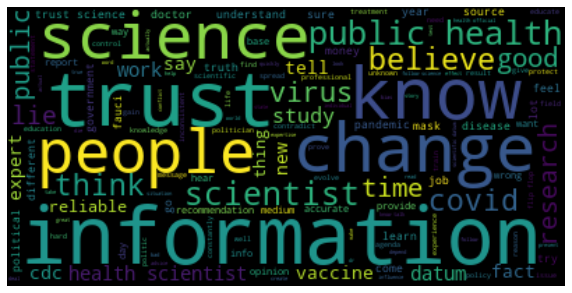

In [123]:
from wordcloud import WordCloud

text = " ".join(df.scientists.dropna().to_list())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

print("Why public health scientists reliable or unreliable?")

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Why CDC changed recommended isolation period?


(-0.5, 399.5, 199.5, -0.5)

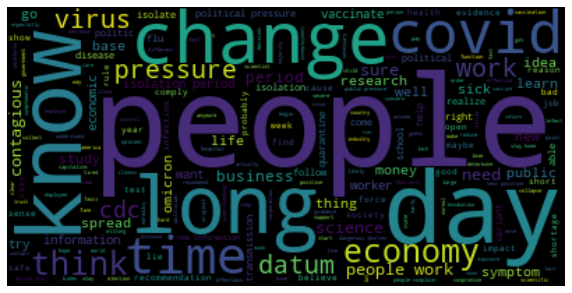

In [122]:
text = " ".join(df.isolation.dropna().to_list())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

print("Why CDC changed recommended isolation period?")

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")